In [1]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/pos-1m-clean/1M_pos_clean_data.npy


In [2]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd

In [3]:
data = np.load('/kaggle/input/pos-1m-clean/1M_pos_clean_data.npy')
data.shape

(995978, 279)

In [5]:
test_ind = [1,10,100]
new_data = np.delete(data,test_ind,axis=0)
new_data.shape

(995975, 279)

**Using mean and std of the spectra as features**

In [6]:
train_data = new_data
new_spec = np.zeros_like(train_data[:,:271])
for i in range(len(train_data)):
    mean_sp = np.mean(train_data[i,:269])
    std_sp = np.std(train_data[i,:269])
    new_spec[i,:269] = (train_data[i,:269] - mean_sp) / std_sp
    new_spec[i,269] = mean_sp
    new_spec[i,270] = std_sp
#     new_spec[i,271] = train_data[i,269]   # rstar
#     new_spec[i,272] = train_data[i,270]   # rplanet
#     new_spec[i,273] = train_data[i,271]   # gp
#     new_spec[i,271] = (np.max(train_data[i,:269])-np.min(train_data[i,:269])) #FH
new_spec.shape

(995975, 271)

## 10K Data 

In [7]:
X = new_spec[:10000]
Y = new_data[:10000,272:]
X.shape, Y.shape

((10000, 271), (10000, 7))

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Y = scaler.fit_transform(Y)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.10, random_state = 42)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9000, 271, 1), (1000, 271, 1), (9000, 7), (1000, 7))

In [11]:
import tensorflow as tf

2024-08-29 18:56:52.389117: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 18:56:52.389262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 18:56:52.531582: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [12]:
# Define the CNN model
def create_model(input_shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling1D())
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D())
    model.add(tf.keras.layers.Conv1D(128, 3, activation='relu'))
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(y_train.shape[1], activation='linear'))
    return model

# Instantiate and compile the model
input_shape = (X_train.shape[1], X_train.shape[2])
model_10k = create_model(input_shape)
opt =  tf.keras.optimizers.Adam(1e-4)
model_10k.compile(optimizer=opt, loss='mse', metrics=['mae','r2_score'])
model_10k.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 269, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 134, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 132, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 66, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 64, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,145,351 (8.18 MB)

 Trainable params: 2,145,351 (8.18 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
exolab=model_10k.fit(X_train, y_train, epochs=50,batch_size=32,
                    validation_split=0.2,shuffle=True)

Epoch 1/50
 46/225 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8791 - mae: 0.8007 - r2_score: 0.1203

I0000 00:00:1724957829.432411      67 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.6553 - mae: 0.6681 - r2_score: 0.3433 - val_loss: 0.3591 - val_mae: 0.4709 - val_r2_score: 0.6405
Epoch 2/50
 47/225 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3684 - mae: 0.4800 - r2_score: 0.6293

W0000 00:00:1724957832.436888      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3516 - mae: 0.4663 - r2_score: 0.6476 - val_loss: 0.3080 - val_mae: 0.4254 - val_r2_score: 0.6916
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2961 - mae: 0.4197 - r2_score: 0.7030 - val_loss: 0.2610 - val_mae: 0.3883 - val_r2_score: 0.7385
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2640 - mae: 0.3933 - r2_score: 0.7340 - val_loss: 0.2425 - val_mae: 0.3707 - val_r2_score: 0.7570
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2462 - mae: 0.3745 - r2_score: 0.7533 - val_loss: 0.2290 - val_mae: 0.3544 - val_r2_score: 0.7705
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2353 - mae: 0.3648 - r2_score: 0.7660 - val_loss: 0.2183 - val_mae: 0.3494 - val_r2_score: 0.7812
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2147 - mae: 0.3482 - r2_score: 0.7846 - val_loss: 0.2027 - val_mae: 0.3349 - val_r2_score: 0.7968
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

In [14]:
model_10k.save("cnn_model_10k_ms.keras")

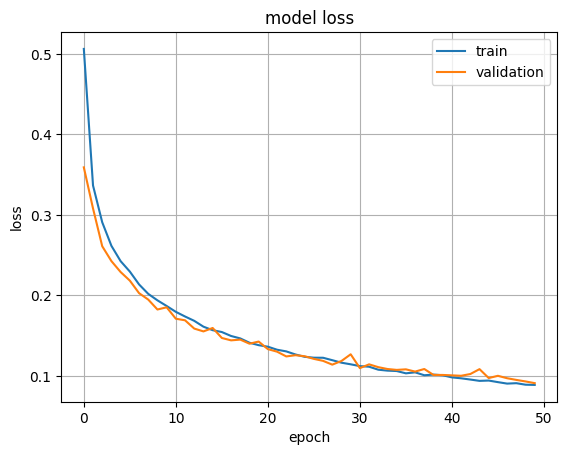

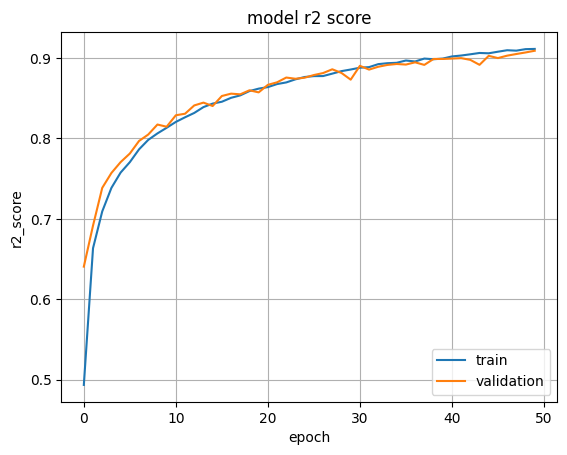

In [15]:
# loss
plt.plot(exolab.history['loss'])
plt.plot(exolab.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid(True)
plt.show()

# r2 score
plt.plot(exolab.history['r2_score'])
plt.plot(exolab.history['val_r2_score'])
plt.title('model r2 score')
plt.ylabel('r2_score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.grid(True)
plt.show()

In [16]:
test_loss,test_mae,test_r2_score = model_10k.evaluate(X_test,y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0834 - mae: 0.1976 - r2_score: 0.9167 


In [17]:
predictions = model_10k.predict(X_test)
predictions.shape

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


W0000 00:00:1724957877.909805      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


(1000, 7)

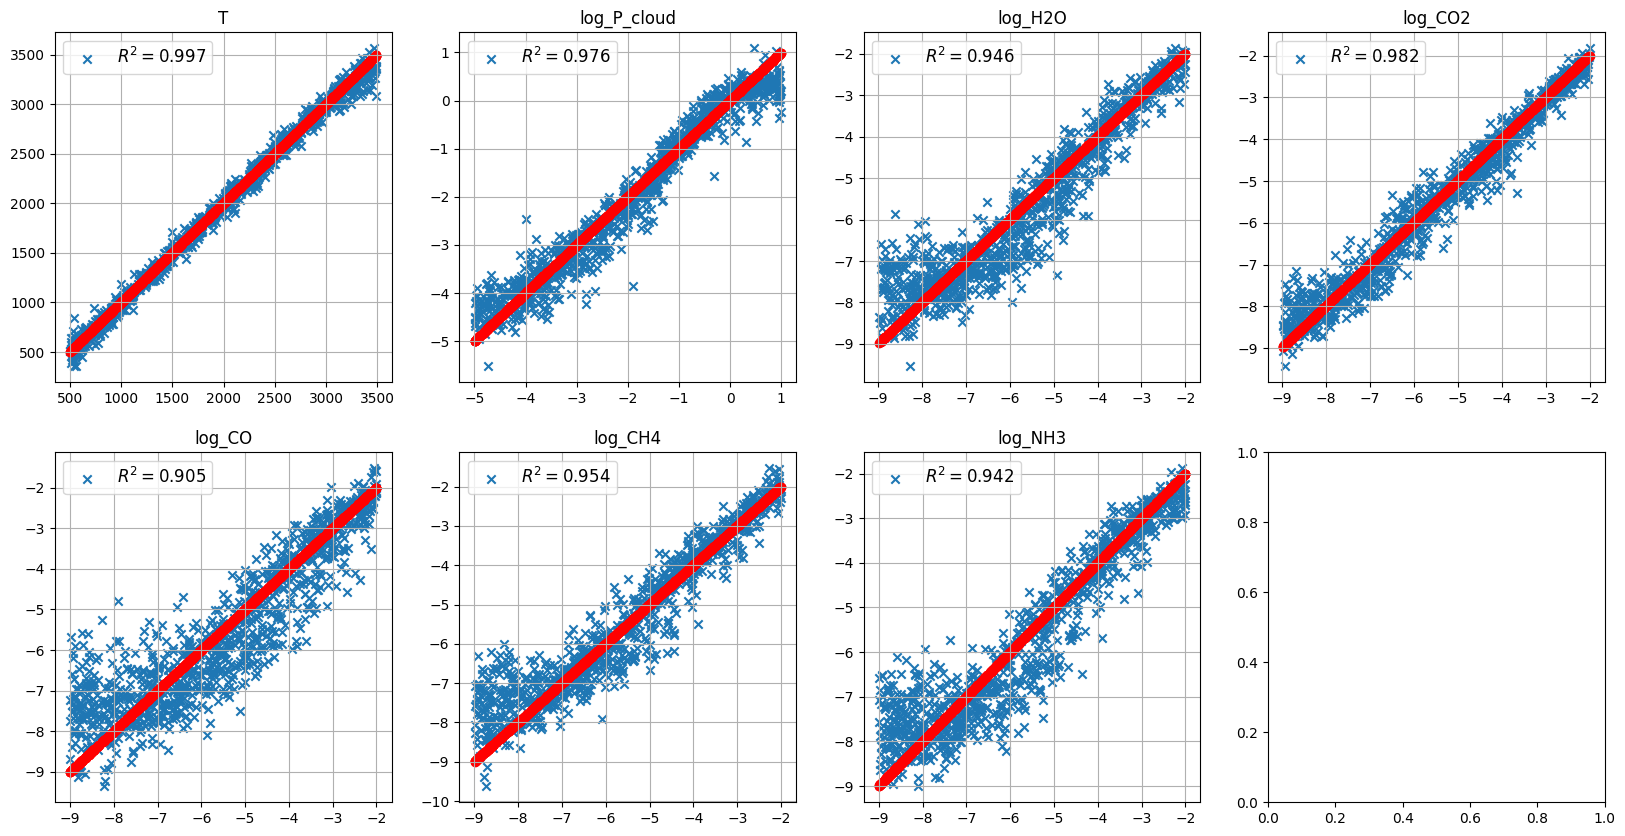

In [18]:
from scipy.stats import pearsonr

keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

y_test_rescaled = scaler.inverse_transform(y_test)
predictions = scaler.inverse_transform(predictions)

for i in range(7):
    if i < 4:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[0,i].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x', label=f'$R^{2} = ${corr:.3f}')
        axs[0,i].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend(loc='upper left',fontsize=12)
        axs[0,i].grid()
    else:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[1,i-4].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x',label=f'$R^{2} = ${corr:.3f}')
        axs[1,i-4].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend(loc= 'upper left',fontsize=12)
        axs[1,i-4].grid()

### Testing on the retrieved planets

In [19]:
file_data = np.load('/kaggle/input/pos-1m-clean/1M_pos_clean_data.npy')

In [21]:
mean = np.mean(file_data[1,:269])
std = np.std(file_data[1,:269])
planetA_spec = (file_data[1,:269] - mean) / std
planetA_spec = np.concatenate([planetA_spec,np.array([mean]),np.array([std])])
planetA_params = file_data[1,269:]
planetA_spec.shape, planetA_params.shape

((271,), (10,))

In [22]:
mean = np.mean(file_data[10,:269])
std = np.std(file_data[10,:269])
planetB_spec = (file_data[10,:269] - mean) / std
planetB_spec = np.concatenate([planetB_spec,np.array([mean]),np.array([std])])
planetB_params = file_data[10,269:]
planetB_spec.shape, planetB_params.shape

((271,), (10,))

In [23]:
mean = np.mean(file_data[100,:269])
std = np.std(file_data[100,:269])
planetC_spec = (file_data[100,:269] - mean) / std
planetC_spec = np.concatenate([planetC_spec,np.array([mean]),np.array([std])])
planetC_params = file_data[100,269:]
planetC_spec.shape, planetC_params.shape

((271,), (10,))

In [24]:
test_planets = np.array([planetA_spec,planetB_spec,planetC_spec])
test_planets = test_planets.reshape(3,271,1)
test_planets.shape

(3, 271, 1)

In [25]:
pred = model_10k.predict(test_planets)
pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


(3, 7)

In [26]:
pred = scaler.inverse_transform(pred)

In [27]:
planetA_pred_10k = pred[0]
print("Predicted values:",planetA_pred_10k)
print("Actual values:",planetA_params[3:])

Predicted values: [ 1.9898416e+03 -6.4752754e-03 -7.7448893e+00 -8.2709866e+00
 -5.0354047e+00 -3.9221957e+00 -4.5306644e+00]
Actual values: [ 2.08383676e+03 -1.94865038e-01 -7.35204337e+00 -8.11423364e+00
 -5.01872241e+00 -3.65232765e+00 -4.16874130e+00]


In [28]:
planetB_pred_10k = pred[1]
print("Predicted values:",planetB_pred_10k)
print("Actual values:",planetB_params[3:])

Predicted values: [ 1.0748521e+03 -1.6683644e-02 -2.9788721e+00 -2.7832868e+00
 -7.4882402e+00 -5.8478832e+00 -5.0502934e+00]
Actual values: [ 1.11335948e+03  1.70457392e-01 -2.78129766e+00 -2.70422089e+00
 -8.81511155e+00 -5.79890730e+00 -5.21304883e+00]


In [29]:
planetC_pred_10k = pred[2]
print("Predicted values:",planetC_pred_10k)
print("Actual values:",planetC_params[3:])

Predicted values: [2665.7627      -3.7345765   -6.1633625   -5.105844    -7.7030277
   -2.942534    -6.546088 ]
Actual values: [ 2.66055847e+03 -3.48554752e+00 -5.39606516e+00 -5.07833705e+00
 -5.97777151e+00 -2.57789940e+00 -5.33643891e+00]


## 100K Data

In [30]:
X = new_spec[:100000]
Y = new_data[:100000,272:]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Y = scaler.fit_transform(Y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.10, random_state = 42)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90000, 271, 1), (10000, 271, 1), (90000, 7), (10000, 7))

In [31]:
input_shape = (X_train.shape[1], X_train.shape[2])
model_100k = create_model(input_shape)
opt =  tf.keras.optimizers.Adam(1e-4)
model_100k.compile(optimizer=opt, loss='mse', metrics=['mae','r2_score'])
model_100k.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 269, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 134, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 132, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 66, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 64, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,145,351 (8.18 MB)

 Trainable params: 2,145,351 (8.18 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
exolab=model_100k.fit(X_train, y_train, epochs=50,batch_size=32,
                    validation_split=0.2,shuffle=True)

Epoch 1/50
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.3787 - mae: 0.4771 - r2_score: 0.6223 - val_loss: 0.1795 - val_mae: 0.3046 - val_r2_score: 0.8213
Epoch 2/50
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1749 - mae: 0.3096 - r2_score: 0.8253 - val_loss: 0.1254 - val_mae: 0.2521 - val_r2_score: 0.8751
Epoch 3/50
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1397 - mae: 0.2718 - r2_score: 0.8601 - val_loss: 0.1051 - val_mae: 0.2252 - val_r2_score: 0.8953
Epoch 4/50
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.1195 - mae: 0.2476 - r2_score: 0.8802 - val_loss: 0.0997 - val_mae: 0.2188 - val_r2_score: 0.9007
Epoch 5/50
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1081 - mae: 0.2337 - r2_score: 0.8919 - val_loss: 0.0879 - val_mae: 0.2035 - val_r2_score: 0.9124
Epoch 6/50
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0994 - mae: 0.2230 - r2_score: 0.9003 - val_loss: 0.0819 - val_mae: 0.1908 - val_r2_score: 0.9184
Epoch 7/50
2250/2250 ━━━━━

In [33]:
model_100k.save("cnn_model_100k_ms.keras")

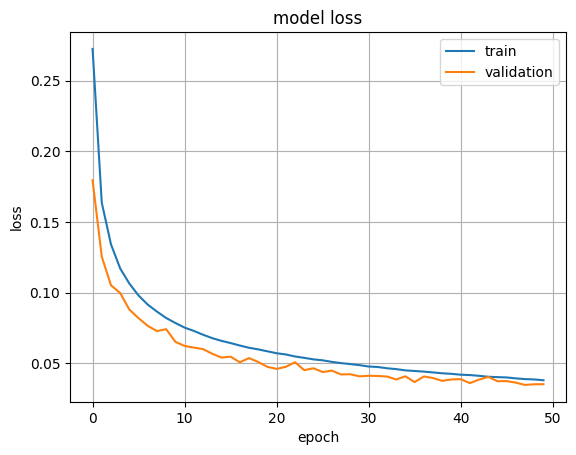

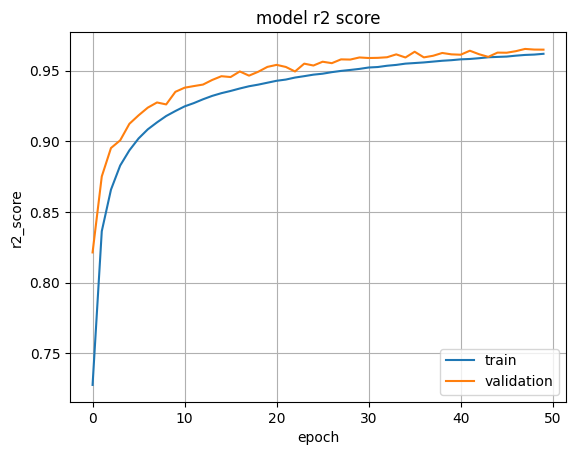

In [34]:
# loss
plt.plot(exolab.history['loss'])
plt.plot(exolab.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid(True)
plt.show()

# r2 score
plt.plot(exolab.history['r2_score'])
plt.plot(exolab.history['val_r2_score'])
plt.title('model r2 score')
plt.ylabel('r2_score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.grid(True)
plt.show()

In [35]:
test_loss,test_mae,test_r2_score = model_100k.evaluate(X_test,y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0345 - mae: 0.1170 - r2_score: 0.9653


In [36]:
predictions = model_100k.predict(X_test)
predictions.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


(10000, 7)

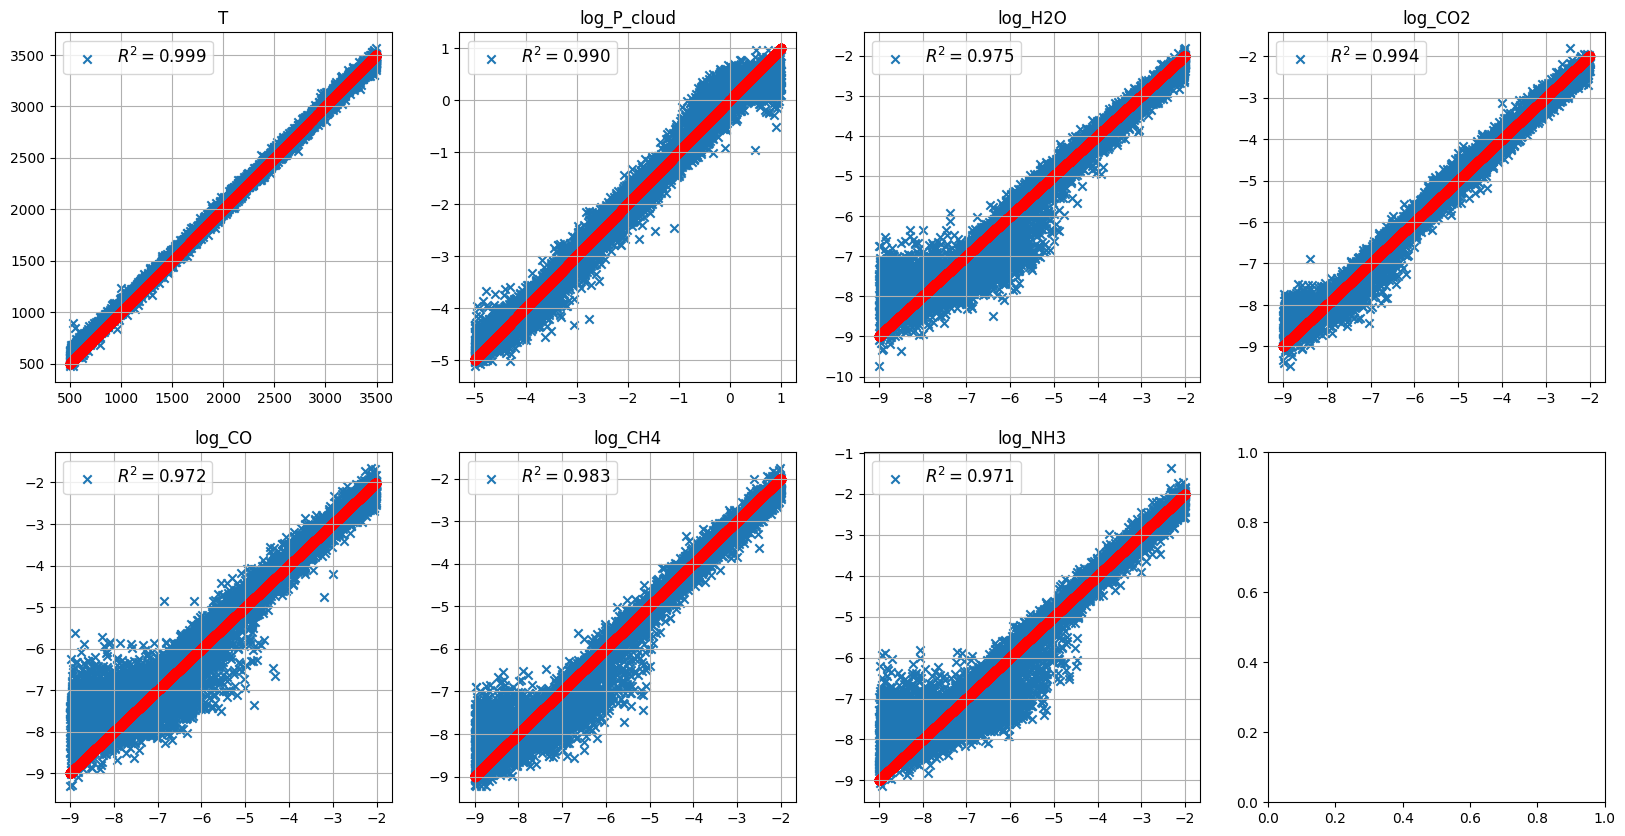

In [37]:
from scipy.stats import pearsonr

keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

y_test_rescaled = scaler.inverse_transform(y_test)
predictions = scaler.inverse_transform(predictions)

for i in range(7):
    if i < 4:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[0,i].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x', label=f'$R^{2} = ${corr:.3f}')
        axs[0,i].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend(loc='upper left',fontsize=12)
        axs[0,i].grid()
    else:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[1,i-4].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x',label=f'$R^{2} = ${corr:.3f}')
        axs[1,i-4].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend(loc= 'upper left',fontsize=12)
        axs[1,i-4].grid()

In [38]:
pred = model_100k.predict(test_planets)
pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


(3, 7)

In [39]:
pred = scaler.inverse_transform(pred)

In [40]:
planetA_pred_100k = pred[0]
print("Predicted values:",planetA_pred_100k)
print("Actual values:",planetA_params[3:])

Predicted values: [ 2.1273948e+03  4.9466780e-01 -7.8979688e+00 -7.9092679e+00
 -4.7774243e+00 -3.6170542e+00 -4.0348558e+00]
Actual values: [ 2.08383676e+03 -1.94865038e-01 -7.35204337e+00 -8.11423364e+00
 -5.01872241e+00 -3.65232765e+00 -4.16874130e+00]


In [41]:
planetB_pred_100k = pred[1]
print("Predicted values:",planetB_pred_100k)
print("Actual values:",planetB_params[3:])

Predicted values: [ 1.1475773e+03  4.3684724e-01 -2.8565264e+00 -2.8722997e+00
 -8.2655411e+00 -6.0792689e+00 -5.2131248e+00]
Actual values: [ 1.11335948e+03  1.70457392e-01 -2.78129766e+00 -2.70422089e+00
 -8.81511155e+00 -5.79890730e+00 -5.21304883e+00]


In [42]:
planetC_pred_100k = pred[2]
print("Predicted values:",planetC_pred_100k)
print("Actual values:",planetC_params[3:])

Predicted values: [2702.109       -3.694562    -5.6265326   -5.1904573   -6.084618
   -2.9954896   -5.655548 ]
Actual values: [ 2.66055847e+03 -3.48554752e+00 -5.39606516e+00 -5.07833705e+00
 -5.97777151e+00 -2.57789940e+00 -5.33643891e+00]


## 1M Data

In [43]:
X = new_spec[:]
Y = new_data[:,272:]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Y = scaler.fit_transform(Y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.10, random_state = 42)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((896377, 271, 1), (99598, 271, 1), (896377, 7), (99598, 7))

In [44]:
input_shape = (X_train.shape[1], X_train.shape[2])
model_1M = create_model(input_shape)
opt =  tf.keras.optimizers.Adam(1e-4)
model_1M.compile(optimizer=opt, loss='mse', metrics=['mae','r2_score'])
model_1M.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 269, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 134, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 132, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 66, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 64, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,145,351 (8.18 MB)

 Trainable params: 2,145,351 (8.18 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
exolab=model_1M.fit(X_train, y_train, epochs=50,batch_size=32,
                    validation_split=0.2,shuffle=True)

Epoch 1/50
22410/22410 ━━━━━━━━━━━━━━━━━━━━ 91s 4ms/step - loss: 0.1871 - mae: 0.3121 - r2_score: 0.8131 - val_loss: 0.0657 - val_mae: 0.1702 - val_r2_score: 0.9343
Epoch 2/50
22410/22410 ━━━━━━━━━━━━━━━━━━━━ 83s 4ms/step - loss: 0.0711 - mae: 0.1834 - r2_score: 0.9289 - val_loss: 0.0473 - val_mae: 0.1407 - val_r2_score: 0.9527
Epoch 3/50
22410/22410 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - loss: 0.0554 - mae: 0.1592 - r2_score: 0.9446 - val_loss: 0.0411 - val_mae: 0.1251 - val_r2_score: 0.9589
Epoch 4/50
22410/22410 ━━━━━━━━━━━━━━━━━━━━ 83s 4ms/step - loss: 0.0476 - mae: 0.1455 - r2_score: 0.9524 - val_loss: 0.0379 - val_mae: 0.1232 - val_r2_score: 0.9621
Epoch 5/50
22410/22410 ━━━━━━━━━━━━━━━━━━━━ 83s 4ms/step - loss: 0.0424 - mae: 0.1353 - r2_score: 0.9576 - val_loss: 0.0370 - val_mae: 0.1194 - val_r2_score: 0.9630
Epoch 6/50
22410/22410 ━━━━━━━━━━━━━━━━━━━━ 83s 4ms/step - loss: 0.0386 - mae: 0.1275 - r2_score: 0.9614 - val_loss: 0.0329 - val_mae: 0.1166 - val_r2_score: 0.9671
Epoch 7/50

In [46]:
model_1M.save("cnn_model_1M_ms.keras")

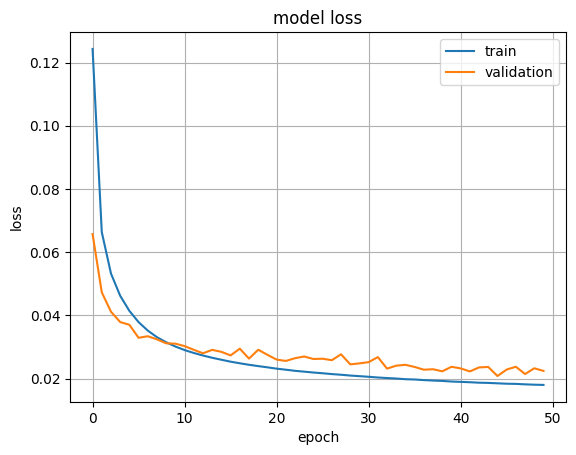

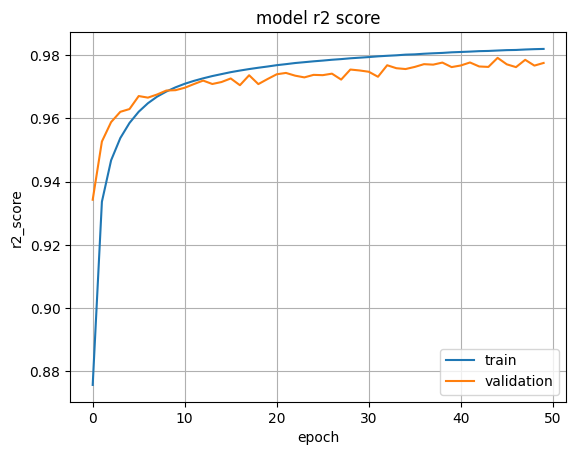

In [47]:
# loss
plt.plot(exolab.history['loss'])
plt.plot(exolab.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid(True)
plt.show()

# r2 score
plt.plot(exolab.history['r2_score'])
plt.plot(exolab.history['val_r2_score'])
plt.title('model r2 score')
plt.ylabel('r2_score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.grid(True)
plt.show()

In [48]:
test_loss,test_mae,test_r2_score = model_1M.evaluate(X_test,y_test)

3113/3113 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0224 - mae: 0.1018 - r2_score: 0.9776


In [49]:
predictions = model_1M.predict(X_test)
predictions.shape

3113/3113 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


(99598, 7)

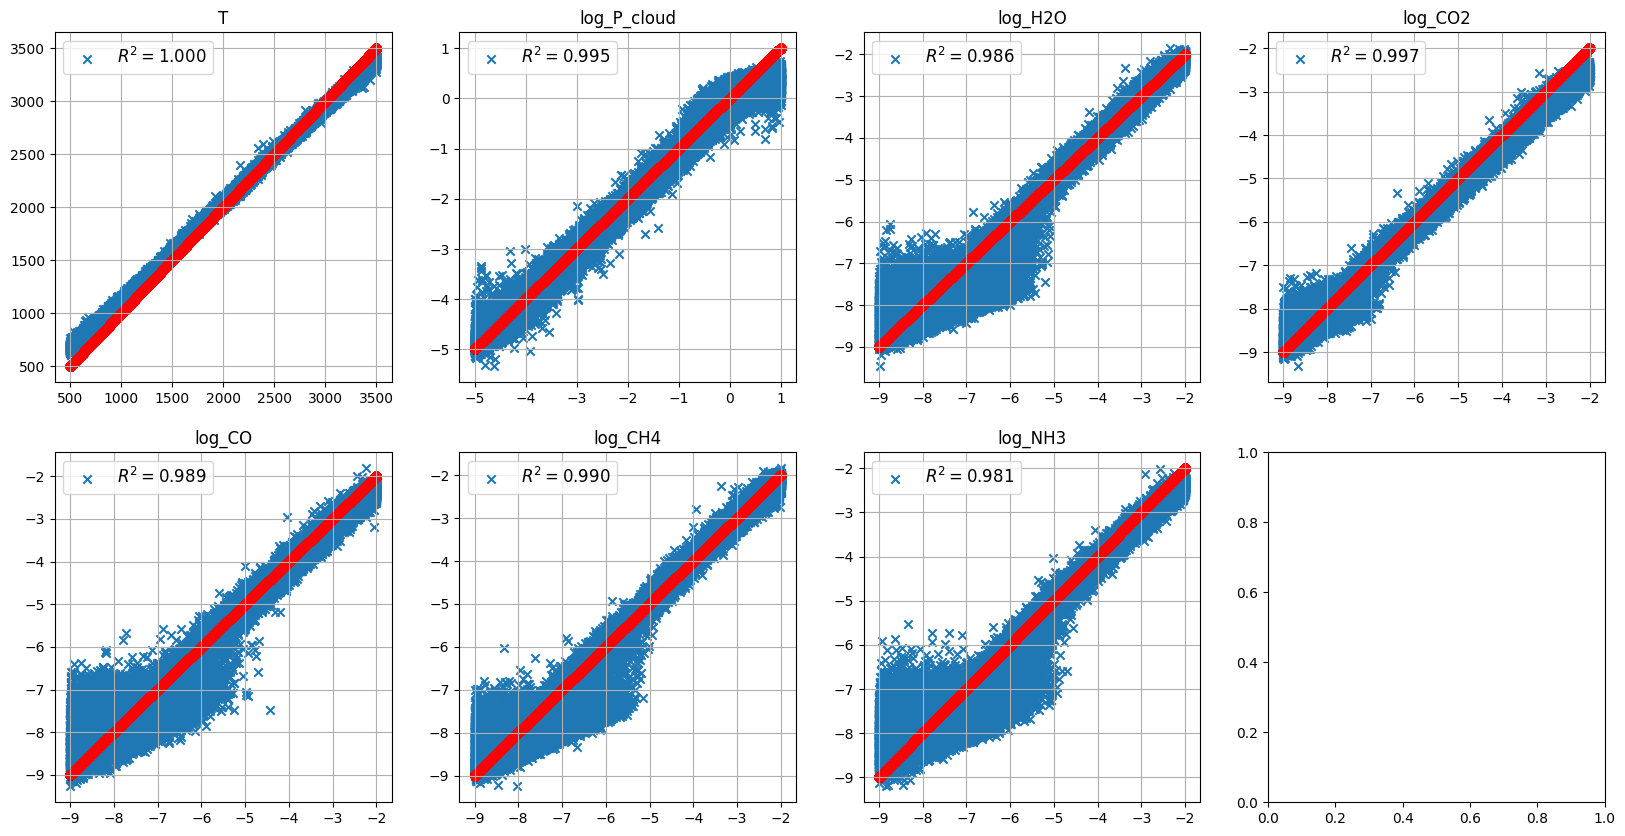

In [50]:
from scipy.stats import pearsonr

keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

y_test_rescaled = scaler.inverse_transform(y_test)
predictions = scaler.inverse_transform(predictions)

for i in range(7):
    if i < 4:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[0,i].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x', label=f'$R^{2} = ${corr:.3f}')
        axs[0,i].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend(loc='upper left',fontsize=12)
        axs[0,i].grid()
    else:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[1,i-4].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x',label=f'$R^{2} = ${corr:.3f}')
        axs[1,i-4].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend(loc= 'upper left',fontsize=12)
        axs[1,i-4].grid()

In [51]:
pred = model_1M.predict(test_planets)
pred = scaler.inverse_transform(pred)
pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


(3, 7)

In [52]:
planetA_pred_1M = pred[0]
print("Predicted values:",planetA_pred_1M)
print("Actual values:",planetA_params[3:])

Predicted values: [ 2.1124746e+03  5.7591502e-02 -7.4765539e+00 -8.1377573e+00
 -5.1154957e+00 -3.6930838e+00 -4.3820066e+00]
Actual values: [ 2.08383676e+03 -1.94865038e-01 -7.35204337e+00 -8.11423364e+00
 -5.01872241e+00 -3.65232765e+00 -4.16874130e+00]


In [53]:
planetB_pred_1M = pred[1]
print("Predicted values:",planetB_pred_1M)
print("Actual values:",planetB_params[3:])

Predicted values: [ 1.2041671e+03  2.3523360e-01 -2.8418097e+00 -3.2845893e+00
 -8.1743155e+00 -5.8564949e+00 -5.3473105e+00]
Actual values: [ 1.11335948e+03  1.70457392e-01 -2.78129766e+00 -2.70422089e+00
 -8.81511155e+00 -5.79890730e+00 -5.21304883e+00]


In [54]:
planetC_pred_1M = pred[2]
print("Predicted values:",planetC_pred_1M)
print("Actual values:",planetC_params[3:])

Predicted values: [2627.3691      -3.570971    -5.7257633   -5.6172366   -6.3273067
   -2.934572    -5.8651695]
Actual values: [ 2.66055847e+03 -3.48554752e+00 -5.39606516e+00 -5.07833705e+00
 -5.97777151e+00 -2.57789940e+00 -5.33643891e+00]


### Comparison plots

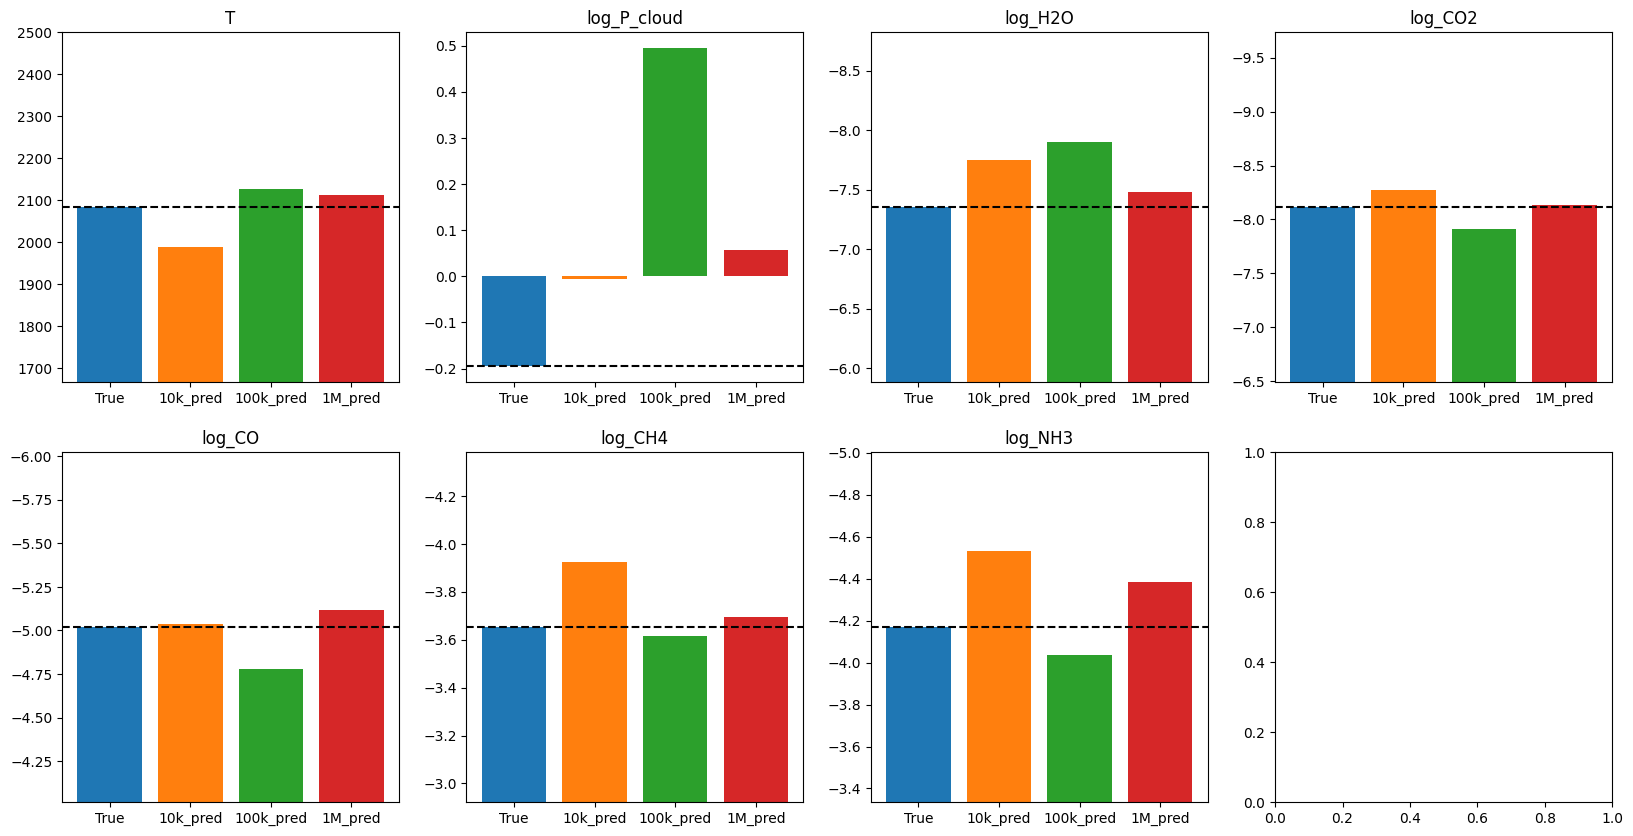

In [55]:
labels1 = ['True']
labels2 = ['10k_pred']
labels3 = ['100k_pred']
labels4 = ['1M_pred']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

for i in range(7):
    if i < 2:
        axs[0,i].bar(labels1, planetA_params[3+i])
        axs[0,i].bar(labels2, planetA_pred_10k[i])
        axs[0,i].bar(labels3, planetA_pred_100k[i])
        axs[0,i].bar(labels4, planetA_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetA_params[3+i],color='black', linestyle='--')
        axs[0,0].set_ylim(0.80*planetA_params[3],1.20*planetA_params[3])
    elif i<4 and i>1:
        axs[0,i].bar(labels1, planetA_params[3+i])
        axs[0,i].bar(labels2, planetA_pred_10k[i])
        axs[0,i].bar(labels3, planetA_pred_100k[i])
        axs[0,i].bar(labels4, planetA_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetA_params[3+i],color='black', linestyle='--')
        axs[0,i].invert_yaxis()
        axs[0,i].set_ylim(0.80*planetA_params[3+i],1.20*planetA_params[3+i])
    else:
        axs[1,i-4].bar(labels1, planetA_params[3+i])
        axs[1,i-4].bar(labels2, planetA_pred_10k[i])
        axs[1,i-4].bar(labels3, planetA_pred_100k[i])
        axs[1,i-4].bar(labels4, planetA_pred_1M[i])
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].axhline(y=planetA_params[3+i],color='black', linestyle='--')
        axs[1,i-4].invert_yaxis()
        axs[1,i-4].set_ylim(0.80*planetA_params[3+i],1.20*planetA_params[3+i])
        
plt.savefig('comparison_plot1.png')

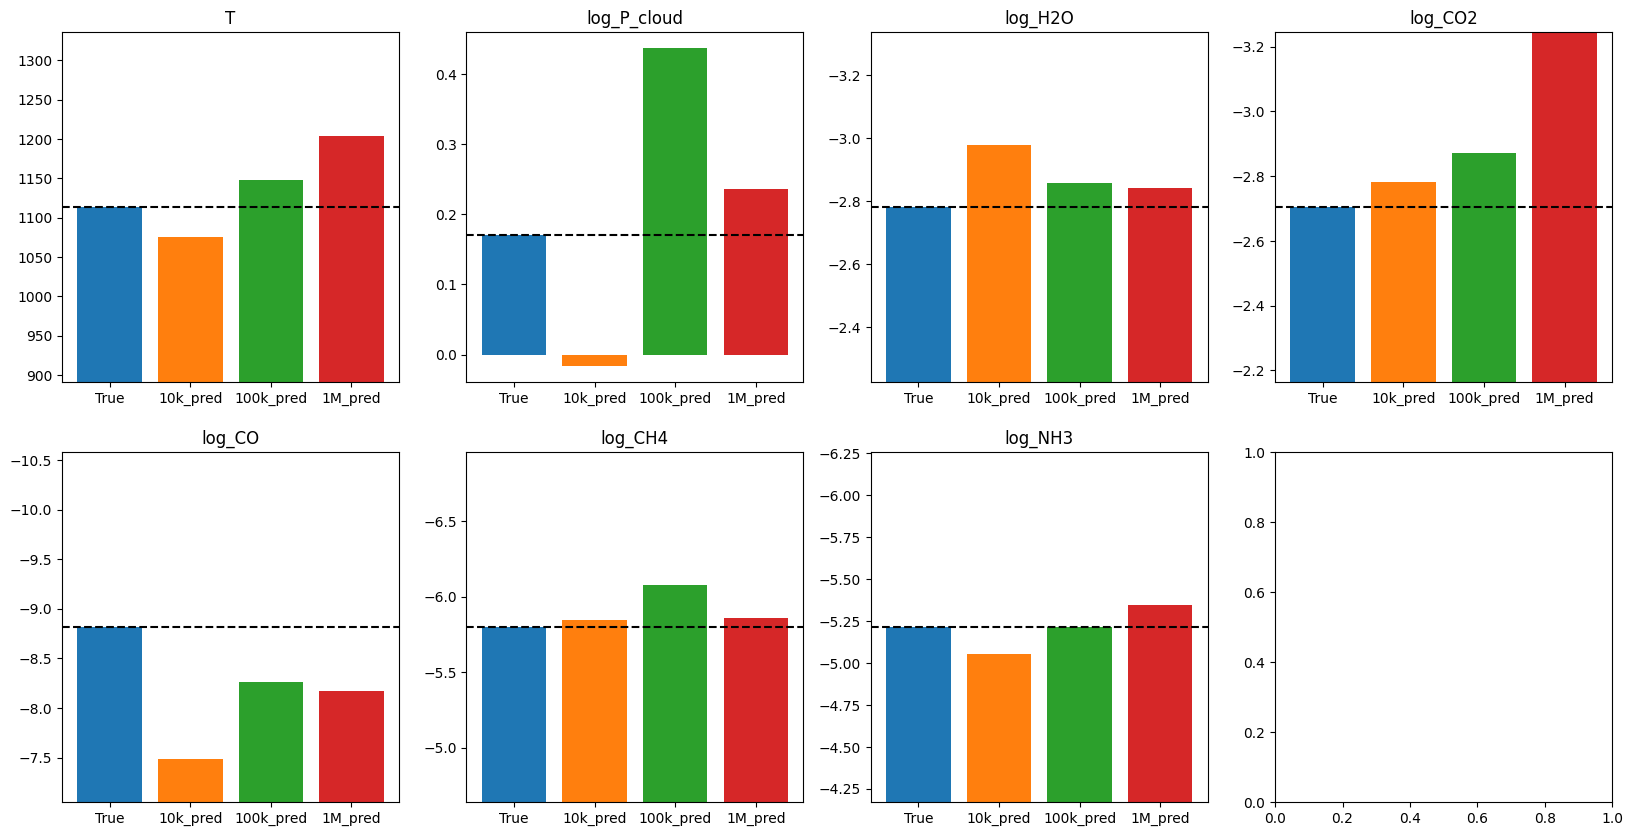

In [56]:
labels1 = ['True']
labels2 = ['10k_pred']
labels3 = ['100k_pred']
labels4 = ['1M_pred']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

for i in range(7):
    if i < 2:
        axs[0,i].bar(labels1, planetB_params[3+i])
        axs[0,i].bar(labels2, planetB_pred_10k[i])
        axs[0,i].bar(labels3, planetB_pred_100k[i])
        axs[0,i].bar(labels4, planetB_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetB_params[3+i],color='black', linestyle='--')
        axs[0,0].set_ylim(0.80*planetB_params[3],1.20*planetB_params[3])
    elif i<4 and i>1:
        axs[0,i].bar(labels1, planetB_params[3+i])
        axs[0,i].bar(labels2, planetB_pred_10k[i])
        axs[0,i].bar(labels3, planetB_pred_100k[i])
        axs[0,i].bar(labels4, planetB_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetB_params[3+i],color='black', linestyle='--')
        axs[0,i].invert_yaxis()
        axs[0,i].set_ylim(0.80*planetB_params[3+i],1.20*planetB_params[3+i])
    else:
        axs[1,i-4].bar(labels1, planetB_params[3+i])
        axs[1,i-4].bar(labels2, planetB_pred_10k[i])
        axs[1,i-4].bar(labels3, planetB_pred_100k[i])
        axs[1,i-4].bar(labels4, planetB_pred_1M[i])
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].axhline(y=planetB_params[3+i],color='black', linestyle='--')
        axs[1,i-4].invert_yaxis()
        axs[1,i-4].set_ylim(0.80*planetB_params[3+i],1.20*planetB_params[3+i])
        
plt.savefig('comparison_plot2.png')

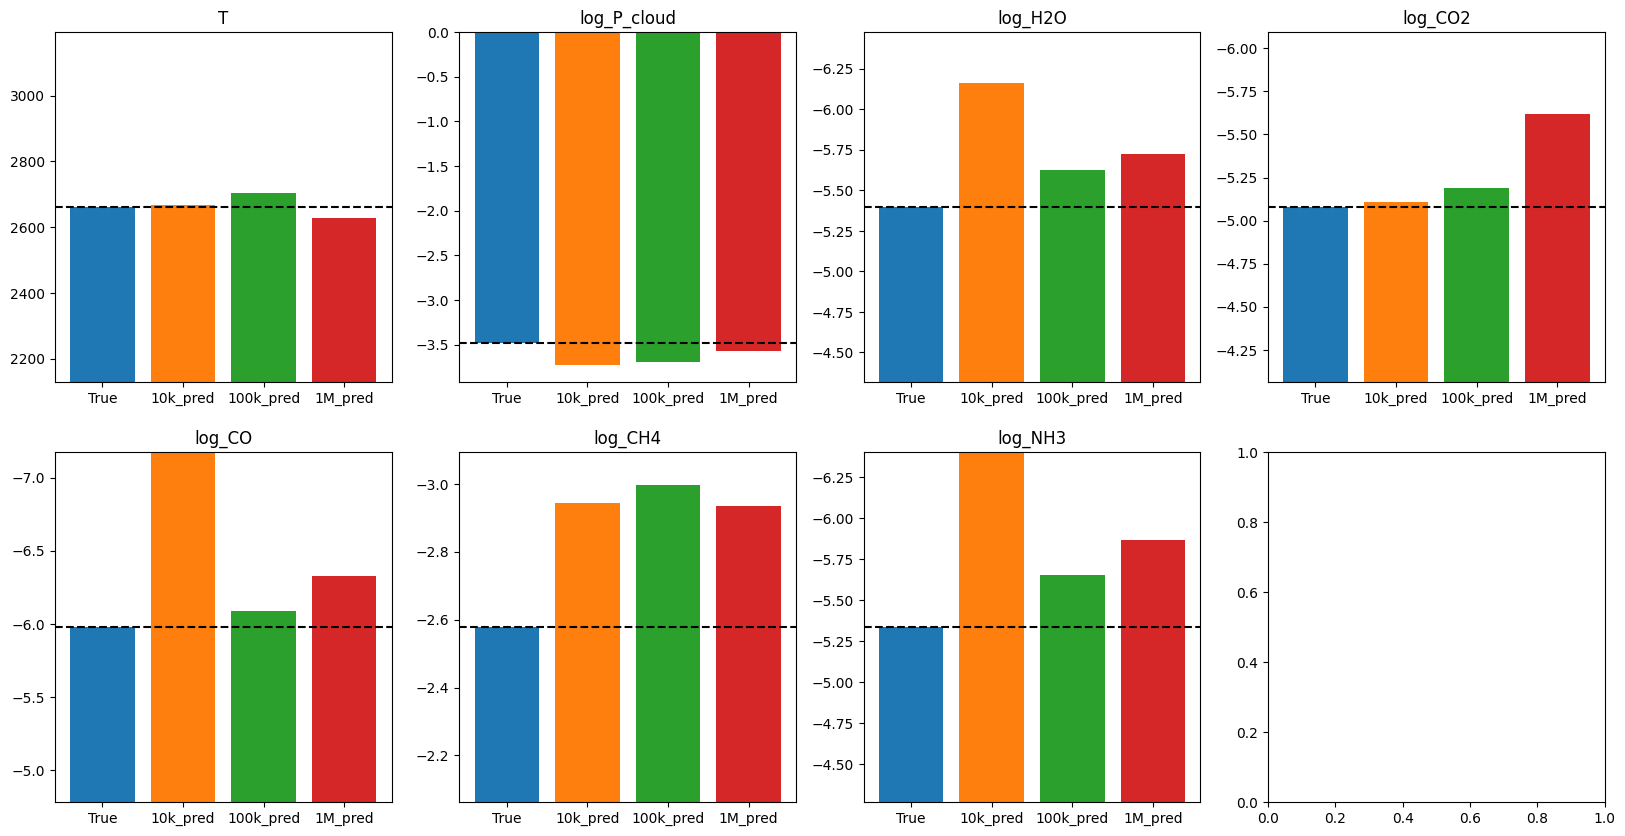

In [57]:
labels1 = ['True']
labels2 = ['10k_pred']
labels3 = ['100k_pred']
labels4 = ['1M_pred']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

for i in range(7):
    if i < 2:
        axs[0,i].bar(labels1, planetC_params[3+i])
        axs[0,i].bar(labels2, planetC_pred_10k[i])
        axs[0,i].bar(labels3, planetC_pred_100k[i])
        axs[0,i].bar(labels4, planetC_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetC_params[3+i],color='black', linestyle='--')
        axs[0,0].set_ylim(0.80*planetC_params[3],1.20*planetC_params[3])
    elif i<4 and i>1:
        axs[0,i].bar(labels1, planetC_params[3+i])
        axs[0,i].bar(labels2, planetC_pred_10k[i])
        axs[0,i].bar(labels3, planetC_pred_100k[i])
        axs[0,i].bar(labels4, planetC_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetC_params[3+i],color='black', linestyle='--')
        axs[0,i].invert_yaxis()
        axs[0,i].set_ylim(0.80*planetC_params[3+i],1.20*planetC_params[3+i])
    else:
        axs[1,i-4].bar(labels1, planetC_params[3+i])
        axs[1,i-4].bar(labels2, planetC_pred_10k[i])
        axs[1,i-4].bar(labels3, planetC_pred_100k[i])
        axs[1,i-4].bar(labels4, planetC_pred_1M[i])
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].axhline(y=planetC_params[3+i],color='black', linestyle='--')
        axs[1,i-4].invert_yaxis()
        axs[1,i-4].set_ylim(0.80*planetC_params[3+i],1.20*planetC_params[3+i])
        
plt.savefig('comparison_plot3.png')